In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import Metadata
from sdv.single_table import TVAESynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

print("All required libraries imported successfully.")

All required libraries imported successfully.


In [2]:
# 1. Load the original 20 records
data = pd.read_csv('labeled_ml_input.csv')
data.columns = ['Age', 'Gender', 'District', 'Education_Level', 'Qualification', 
                'Years_Experience', 'Languages_Spoken', 'Care_Category', 
                'Care_Service_Type', 'Preferred_Time', 'Expected_Salary', 'Match_Decision']

def clean_salary(val):
    val = str(val).replace(',', '').strip()
    if '-' in val:
        try:
            parts = val.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        except: 
            return 0.0
    try: 
        return float(val)
    except: 
        return 0.0

data['Expected_Salary'] = data['Expected_Salary'].apply(clean_salary)

print("Data loaded and preprocessed.")

# Dataset Validation
print("\nDataset Validation:")
print("Total records: {}".format(len(data)))
print("Total features: {}".format(len(data.columns) - 1))

missing_count = data.isnull().sum().sum()
if missing_count > 0:
    print("Missing values found: {}".format(missing_count))
else:
    print("No missing values detected")

# Handle missing values and duplicates
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if data[col].dtype == 'object':
            data[col].fillna('Unknown', inplace=True)
        else:
            data[col].fillna(data[col].median(), inplace=True)

duplicate_count = data.duplicated().sum()
if duplicate_count > 0:
    print("Duplicate records found: {}".format(duplicate_count))
    data = data.drop_duplicates()
    print("Duplicates removed")
else:
    print("No duplicate records found")

print("\nTarget variable distribution:")
print(data['Match_Decision'].value_counts())

class_counts = data['Match_Decision'].value_counts()
if len(class_counts) >= 2:
    print("Dataset validation PASSED: {} classes detected".format(len(class_counts)))
else:
    print("WARNING: Only one class found")

print("Dataset validation complete.")

Data loaded and preprocessed.

Dataset Validation:
Total records: 20
Total features: 11
Missing values found: 6
No duplicate records found

Target variable distribution:
Match_Decision
Rejected    11
Accepted     9
Name: count, dtype: int64
Dataset validation PASSED: 2 classes detected
Dataset validation complete.


/var/folders/49/7cnvwdkx1wq3g1dg2trkfc500000gn/T/ipykernel_44635/2610329149.py:39: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [3]:
# 2. Setup Metadata
metadata = Metadata.detect_from_dataframe(data=data, table_name='elderly_data')
multi_value_cols = ['Languages_Spoken', 'Qualification', 'Care_Category']
for col in multi_value_cols:
    metadata.update_column(table_name='elderly_data', column_name=col, sdtype='categorical')

print("Metadata configured.")

# 3. Training TVAE for boosting
print("Initializing TVAE for data boosting...")
tvae = TVAESynthesizer(metadata=metadata, epochs=500)
tvae.fit(data)

# Generate synthetic records to reach 2000 total
synthetic_data = tvae.sample(num_rows=1980)

# Merge and save
final_data = pd.concat([data, synthetic_data], ignore_index=True)
final_data.to_csv('final_ml_dataset.csv', index=False)
print("Dataset boosted to {} records.".format(len(final_data)))

# Validate boosted dataset
print("\nValidating boosted dataset:")
print("Original dataset: {} records".format(len(data)))
print("Synthetic records: {} records".format(len(synthetic_data)))
print("Total boosted dataset: {} records".format(len(final_data)))

print("\nTarget distribution after boosting:")
print(final_data['Match_Decision'].value_counts())

missing_after_boost = final_data.isnull().sum().sum()
if missing_after_boost > 0:
    print("WARNING: Missing values after boosting: {}".format(missing_after_boost))
else:
    print("No missing values in boosted dataset")

print("Boosted dataset validation PASSED")

Metadata configured.
Initializing TVAE for data boosting...


/opt/anaconda3/lib/python3.13/site-packages/sdv/single_table/base.py:134: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



Dataset boosted to 2000 records.

Validating boosted dataset:
Original dataset: 20 records
Synthetic records: 1980 records
Total boosted dataset: 2000 records

Target distribution after boosting:
Match_Decision
Rejected    1004
Accepted     996
Name: count, dtype: int64
No missing values in boosted dataset
Boosted dataset validation PASSED


In [4]:
# 4. Encoding for the model
target_col = "Match_Decision"
categorical_cols = ['Gender', 'District', 'Education_Level', 'Qualification', 
                    'Languages_Spoken', 'Care_Category', 'Care_Service_Type', 'Preferred_Time']

encoders = {}
X = final_data.drop(target_col, axis=1).copy()
y = final_data[target_col]

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].fillna("None").astype(str))
    encoders[col] = le

# 5. Feature scaling
scaler = StandardScaler()
numeric_features = ['Age', 'Years_Experience', 'Expected_Salary']
X[numeric_features] = scaler.fit_transform(X[numeric_features])

print("Encoding and scaling completed.")

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split into training and testing sets.")
print("Training samples: {}".format(len(X_train)))
print("Testing samples: {}".format(len(X_test)))

# 7. Build and train Random Forest model
print("Training model...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Training complete.")

# 8. Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Encoding and scaling completed.
Data split into training and testing sets.
Training samples: 1600
Testing samples: 400
Training model...
Training complete.
Model Accuracy: 82.00%

Classification Report:
              precision    recall  f1-score   support

    Accepted       0.80      0.86      0.83       199
    Rejected       0.85      0.78      0.81       201

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



Generating training visualization...


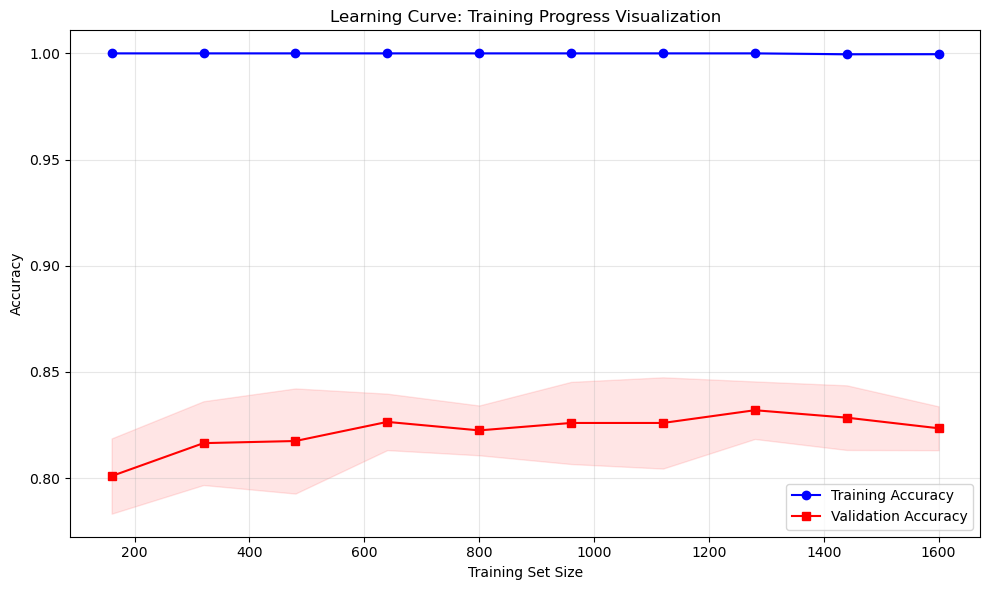

In [5]:
# 9. Visualization of training progress
print("Generating training visualization...")

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='red', marker='s')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Training Progress Visualization')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Generating confusion matrix...


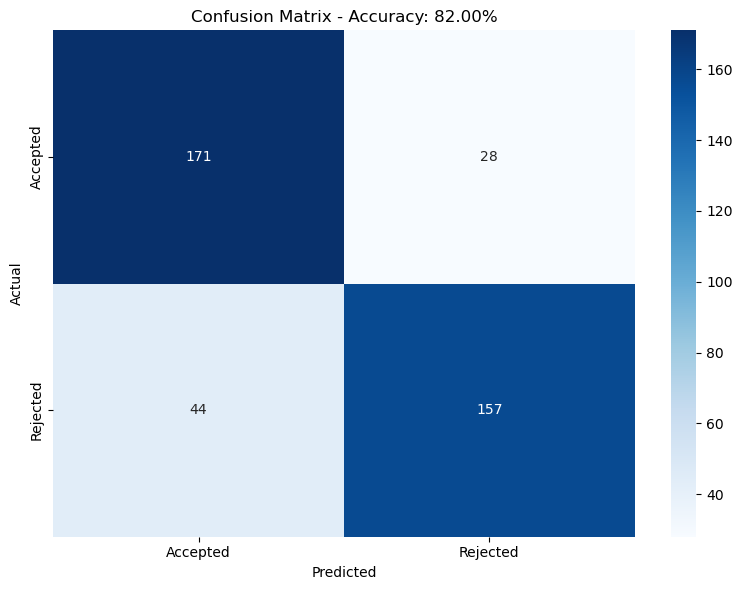

In [6]:
# 10. Confusion matrix
print("Generating confusion matrix...")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Accuracy: {:.2f}%'.format(accuracy * 100))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


Generating feature importance visualization...


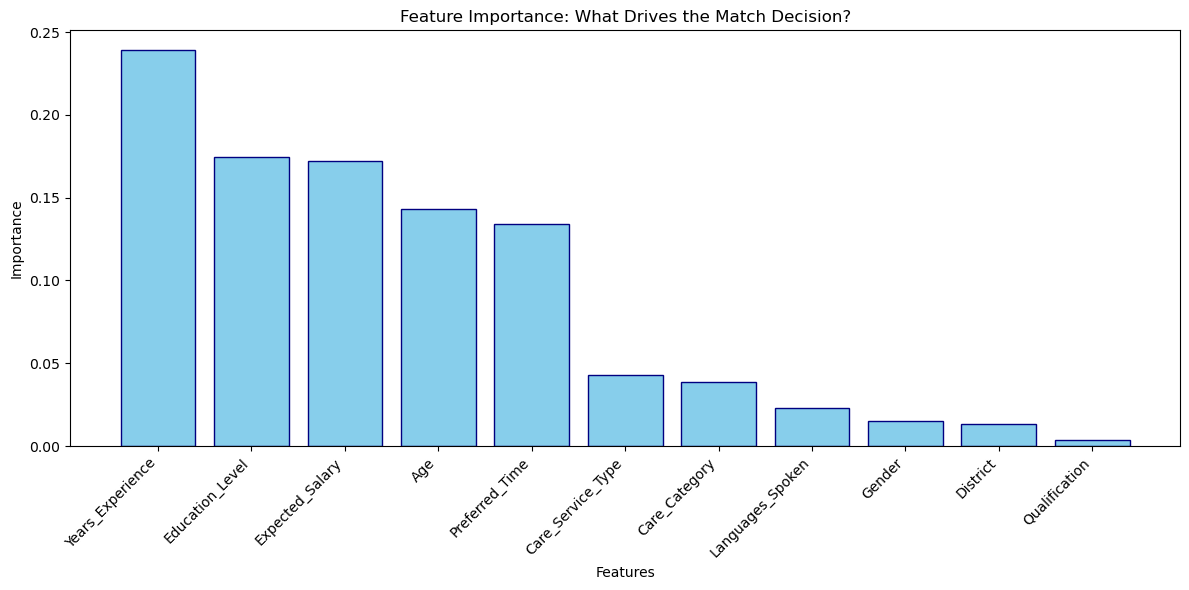

Model saved for backend.


In [7]:
# 11. Feature importance
print("Generating feature importance visualization...")

importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance: What Drives the Match Decision?")
plt.bar(range(len(importances)), importances[indices], align="center", color='skyblue', edgecolor='navy')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()

plt.show()

# 12. Save for backend
joblib.dump({
    'model': model,
    'encoders': encoders,
    'scaler': scaler,
    'feature_names': list(X.columns)
}, 'caregiver_matcher.pkl')

print("Model saved for backend.")